In [1]:
import os
import sys
import argparse

print(os.getcwd())
os.chdir("../../")
os.getcwd()

sys.argv = ["view", "--config", "config/multi_task_cross_stitch.yaml"]

parser = argparse.ArgumentParser()
parser.add_argument("--config", type=str, required=True, help="Path to the config file")
args = parser.parse_args()

print(args.config)

/data01/dl23vitcas/dl_project/src/multi_task_cross_stitch
config/multi_task_cross_stitch.yaml


In [2]:
from config_experiments import config
from torchvision.transforms import transforms
from dataloader import VOC08Attr
import matplotlib.pyplot as plt
from model import ObjectDetectionModel, AttributePredictionModel, CrossStitchNet
from utils import set_device
import torch
from bbox_transform import resize_bounding_boxes, apply_nms
import matplotlib.patches as patches
import torchvision

In [3]:
transform_val = transform = transforms.Compose(
    [
        transforms.Resize(
            size=config["transform"]["resize_values"],
            max_size=config["transform"]["max_size"],
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=config["transform"]["mean"], std=config["transform"]["std"]
        ),
    ]
)

In [4]:
model_path = "../dl_project/experiments/cross_stitch/2024-08-28_09-27-03/models/best_model_epoch_50.pth"

device = set_device(config["global"]["gpu_id"])
model = CrossStitchNet(
    ObjectDetectionModel().backbone, AttributePredictionModel().backbone
).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [5]:
val_data = VOC08Attr(train=False, transform=None)
val_data_for_model = VOC08Attr(train=False, transform=transform_val)

# Cross-stitch - Object Detection


In [6]:
def inference_obj(idx):
    img_transform, img_size_orig_transform, _, _, _, ss_rois_transform = (
        val_data_for_model[idx]
    )
    image, img_size_orig, gt_class, gt_bbox, gt_attributes, ss_rois = val_data[idx]
    img_transform = img_transform.unsqueeze(0).to(device)
    ss_rois_transform = ss_rois_transform.to(device)

    indices_batch = torch.zeros(ss_rois_transform.shape[0], device=device).unsqueeze(-1)

    cls_max_score_net, max_score_net, bboxs_net = model.prediction_img(
        img_transform, ss_rois_transform, indices_batch
    )

    bboxs_net = resize_bounding_boxes(
        bboxs_net,
        orig_size=(img_transform.shape[3], img_transform.shape[2]),
        new_size=img_size_orig_transform,
    )

    pred_bbox, pred_class, pred_score = apply_nms(
        cls_max_score_net, max_score_net, bboxs_net
    )
    pred_bbox, pred_class, pred_score = (
        pred_bbox.cpu(),
        pred_class.cpu(),
        pred_score.cpu(),
    )
    return image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score

In [7]:
def plot_inference_obj(image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score):
    im = image
    fig, ax = plt.subplots()
    ax.imshow(im)

    for gt_el in gt_bbox:
        x_min, y_min, x_max, y_max = gt_el

        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor="g",
            facecolor="none",
        )
        ax.add_patch(rect)

    for pred_el in pred_bbox:
        x_min, y_min, x_max, y_max = pred_el

        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)

    print("NET")
    for box, c, score in zip(pred_bbox, pred_class, pred_score):
        print(
            f"{box.int()} \t class: {c.item()} ({val_data.id2category[c.item()]}) \tscore: {score.item():.3f}"
        )

    print("\nGT")

    for box, c in zip(gt_bbox, gt_class):
        print(f"{box.int()} \t class: {c.item()} ({val_data.id2category[c.item()]})")
    plt.show()

IDX: 498

NET
tensor([193, 322, 229, 335], dtype=torch.int32) 	 class: 6 (car) 	score: 0.960
tensor([302, 312, 321, 323], dtype=torch.int32) 	 class: 6 (car) 	score: 0.869
tensor([219,  35, 291, 181], dtype=torch.int32) 	 class: 9 (boat) 	score: 0.869
tensor([459, 330, 498, 367], dtype=torch.int32) 	 class: 12 (pottedplant) 	score: 0.908
tensor([465, 329, 485, 348], dtype=torch.int32) 	 class: 12 (pottedplant) 	score: 0.592
tensor([422, 155, 500, 325], dtype=torch.int32) 	 class: 16 (bird) 	score: 0.544

GT
tensor([190, 321, 231, 335], dtype=torch.int32) 	 class: 6 (car)
tensor([245, 312, 293, 328], dtype=torch.int32) 	 class: 6 (car)


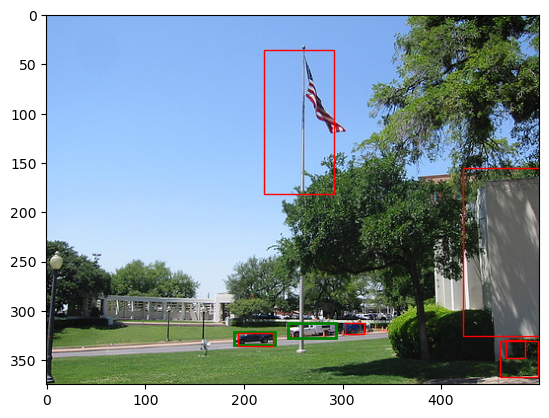

In [8]:
idx = torch.randint(low=0, high=len(val_data), size=(1,))

print(f"IDX: {idx.item()}\n")
image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score = inference_obj(idx=idx)
plot_inference_obj(image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def inference_obj(idx):
    img_transform, img_size_orig_transform, _, _, _, ss_rois_transform = (
        val_data_for_model[idx]
    )
    image, img_size_orig, gt_class, gt_bbox, gt_attributes, ss_rois = val_data[idx]
    img_transform = img_transform.unsqueeze(0).to(device)
    ss_rois_transform = ss_rois_transform.to(device)

    indices_batch = torch.zeros(ss_rois_transform.shape[0], device=device).unsqueeze(-1)

    cls_max_score_net, max_score_net, bboxs_net = model.prediction_img(
        img_transform, ss_rois_transform, indices_batch
    )

    bboxs_net = resize_bounding_boxes(
        bboxs_net,
        orig_size=(img_transform.shape[3], img_transform.shape[2]),
        new_size=img_size_orig_transform,
    )

    pred_bbox, pred_class, pred_score = apply_nms(
        cls_max_score_net, max_score_net, bboxs_net
    )
    pred_bbox, pred_class, pred_score = (
        pred_bbox.cpu(),
        pred_class.cpu(),
        pred_score.cpu(),
    )
    return image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score


def plot_inference_obj_multiple(images_data, indices):
    fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 righe, 4 colonne
    axs = axs.ravel()  # per iterare facilmente sugli assi

    for i, (image, gt_bbox, gt_class, pred_bbox, pred_class, pred_score) in enumerate(
        images_data
    ):
        ax = axs[i]
        ax.imshow(image)

        for gt_el in gt_bbox:
            x_min, y_min, x_max, y_max = gt_el
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor="g",
                facecolor="none",
            )
            ax.add_patch(rect)

        for pred_el in pred_bbox:
            x_min, y_min, x_max, y_max = pred_el
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=1,
                edgecolor="r",
                facecolor="none",
            )
            ax.add_patch(rect)

        ax.set_title(f"Image {indices[i]}")
        ax.axis("off")  # Nascondi assi

        """
        print(f"Image {i + 1} - NET")
        for box, c, score in zip(pred_bbox, pred_class, pred_score):
            print(
                f"{box.int()} \t class: {c.item()} ({val_data.id2category[c.item()]}) \tscore: {score.item():.3f}"
            )

        print(f"\nImage {i + 1} - GT")
        for box, c in zip(gt_bbox, gt_class):
            print(
                f"{box.int()} \t class: {c.item()} ({val_data.id2category[c.item()]})"
            )
        """
    plt.tight_layout()
    plt.show()

tensor([1233, 1297, 1351, 1719,  151, 1662, 1778, 1619])


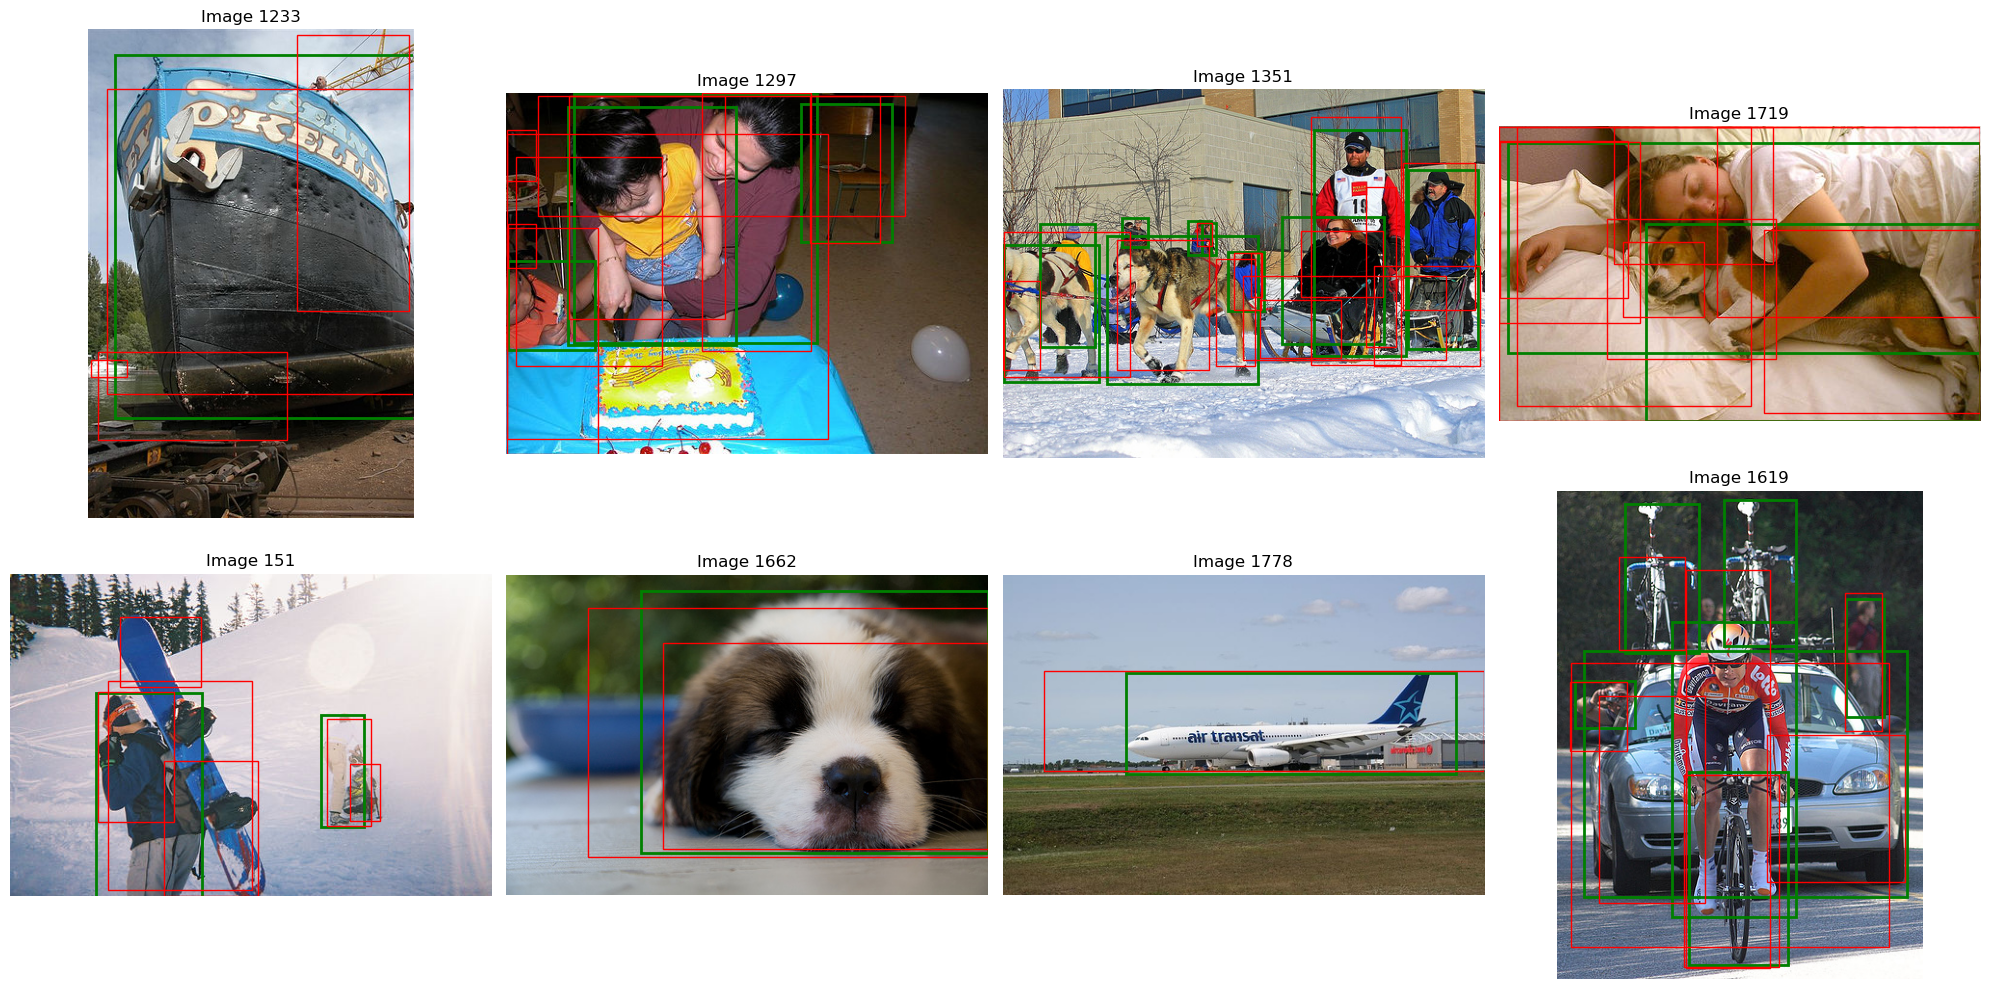

In [10]:
# Seleziona 8 indici casuali dal dataset di validazione
indices = torch.randint(low=0, high=len(val_data), size=(8,))
print(indices)

# Esegui inferenza e colleziona i risultati
images_data = [inference_obj(idx.item()) for idx in indices]

# Plot dei risultati
plot_inference_obj_multiple(images_data, indices)

tensor([2114,  149, 1714, 1326,  604, 1393,  271,  197])


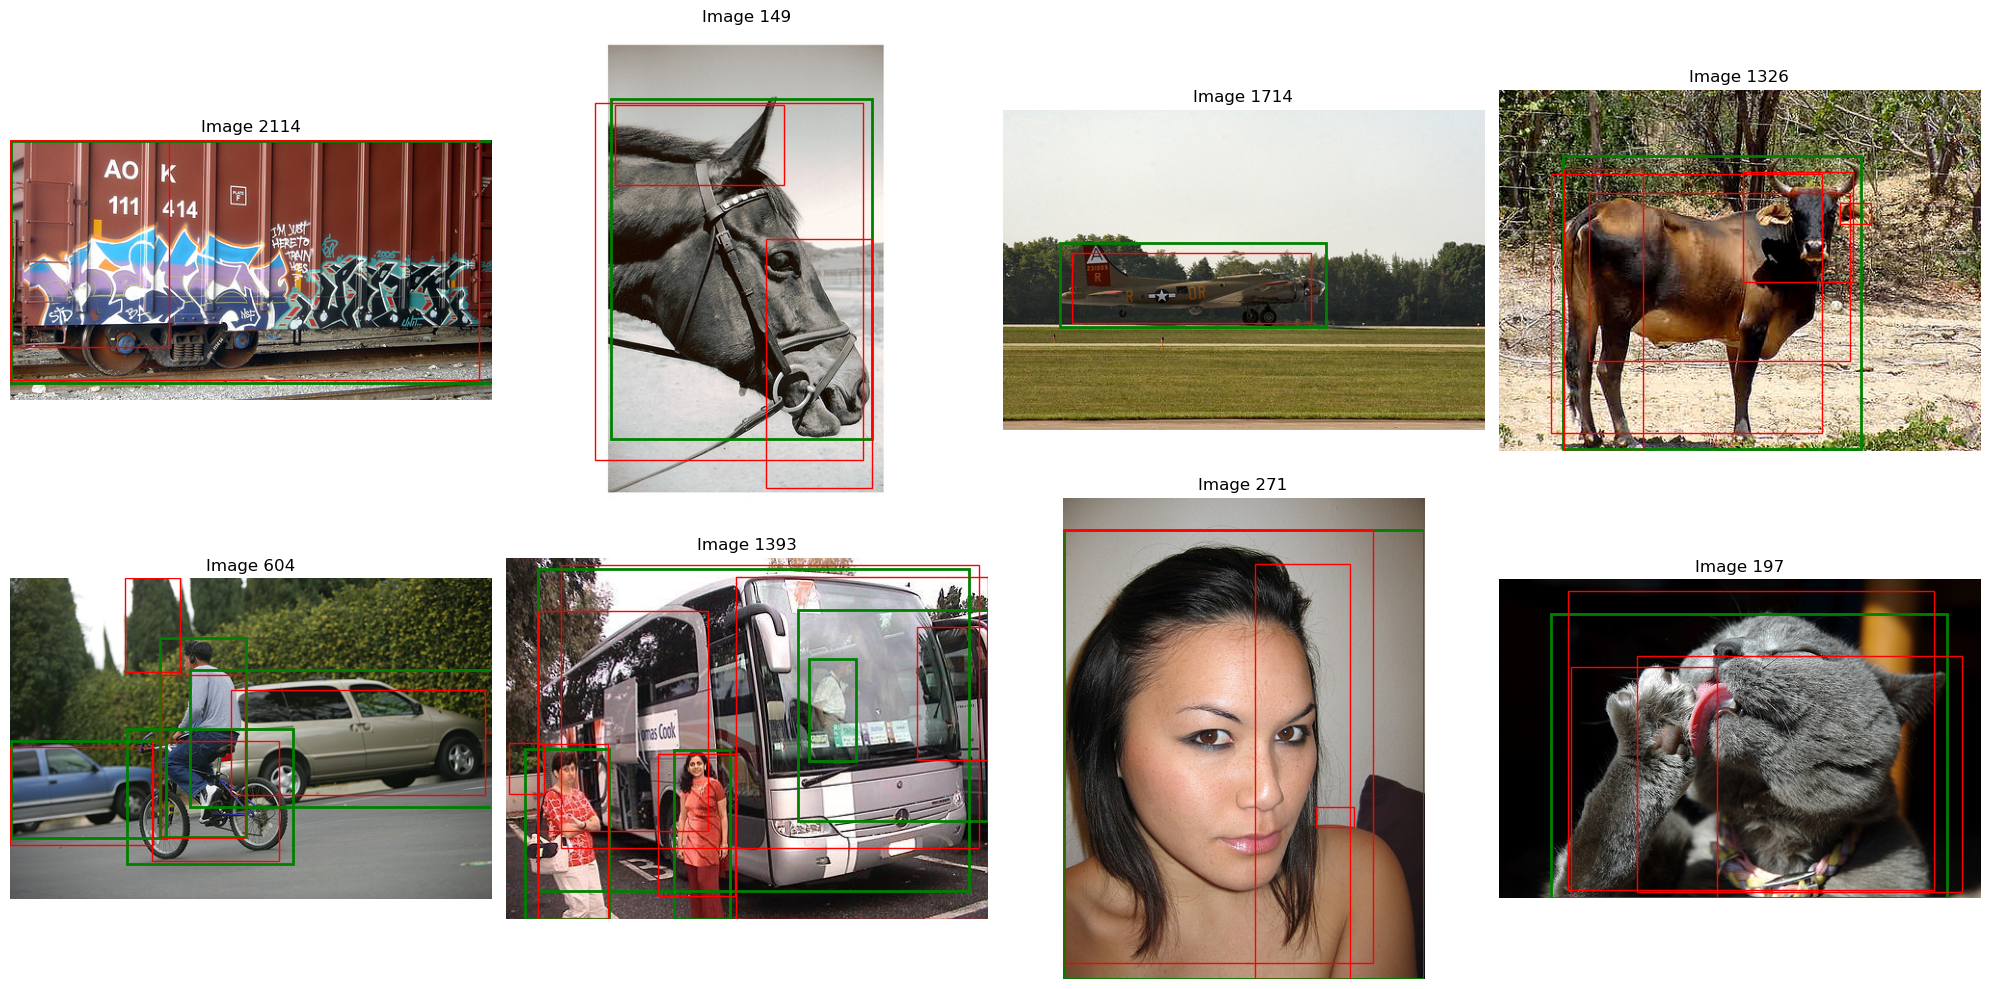

In [11]:
# Seleziona 8 indici casuali dal dataset di validazione
indices = [2114, 149, 1714, 1326, 604, 1393, 271, 197]
indices = torch.tensor(indices)
print(indices)

# Esegui inferenza e colleziona i risultati
images_data = [inference_obj(idx.item()) for idx in indices]

# Plot dei risultati
plot_inference_obj_multiple(images_data, indices)

# Cross-stitch - Attribute Prediction


In [12]:
def inference_attr(idx):
    img_transform, _, _, gt_bbox_transform, _, _ = val_data_for_model[idx]
    img_transform = img_transform.unsqueeze(0).to(device)
    gt_bbox_transform = gt_bbox_transform.to(device)

    image, _, gt_class, gt_bbox, gt_attributes, _ = val_data[idx]

    indices_batch = torch.zeros(gt_bbox_transform.shape[0], device=device).unsqueeze(-1)
    pred_attr, pred_score_attr = model.prediction_rois(
        img_transform, gt_bbox_transform, indices_batch
    )
    return (
        image,
        gt_bbox,
        gt_class,
        gt_attributes,
        pred_attr.cpu(),
        pred_score_attr.cpu(),
    )


def get_names_attributes(attributes):
    indices = torch.nonzero(attributes == 1.0, as_tuple=True)[0] + 1
    return [val_data.id2attribute[(idx)] for idx in indices.tolist()]


def plot_inference_attr(
    image, gt_bbox, gt_class, gt_attributes, pred_attr, pred_score_attr
):
    im = image
    fig, ax = plt.subplots()
    ax.imshow(im)

    for gt_el in gt_bbox:
        x_min, y_min, x_max, y_max = gt_el

        rect = patches.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor="g",
            facecolor="none",
        )
        ax.add_patch(rect)

    for i, (box, c, attr) in enumerate(zip(gt_bbox, gt_class, gt_attributes)):
        print("\nBOX:\n")
        print(f"{box.int()} \t class: {c.item()} ({val_data.id2category[c.item()]})")
        print(f"GT Attributes:  {get_names_attributes(attr)}")
        print(f"NET Attributes:  {get_names_attributes(pred_attr[i])}")

    plt.show()

IDX: 604


BOX:

tensor([155,  62, 245, 269], dtype=torch.int32) 	 class: 2 (person)
GT Attributes:  ['Head', 'Ear', 'Nose', 'Mouth', 'Hair', 'Face', 'Eye', 'Torso', 'Hand', 'Arm', 'Leg', 'Foot/Shoe', 'Skin', 'Cloth']
NET Attributes:  ['Occluded', 'Head', 'Ear', 'Nose', 'Hair', 'Torso', 'Hand', 'Arm', 'Leg', 'Foot/Shoe', 'Skin', 'Cloth']

BOX:

tensor([121, 156, 294, 297], dtype=torch.int32) 	 class: 8 (bicycle)
GT Attributes:  ['Occluded', 'Wheel', 'Pedal', 'Handlebars', 'Metal', 'Plastic', 'Shiny']
NET Attributes:  ['Occluded', 'Wheel', 'Pedal', 'Handlebars', 'Text', 'Metal', 'Shiny']

BOX:

tensor([186,  95, 500, 237], dtype=torch.int32) 	 class: 6 (car)
GT Attributes:  ['3D Boxy', 'Occluded', 'Window', 'Wheel', 'Door', 'Taillight', 'Side mirror', 'Metal', 'Shiny']
NET Attributes:  ['3D Boxy', 'Occluded', 'Window', 'Wheel', 'Door', 'Headlight', 'Taillight', 'Side mirror', 'Metal', 'Shiny']

BOX:

tensor([  1, 169, 162, 270], dtype=torch.int32) 	 class: 6 (car)
GT Attributes:  ['3D B

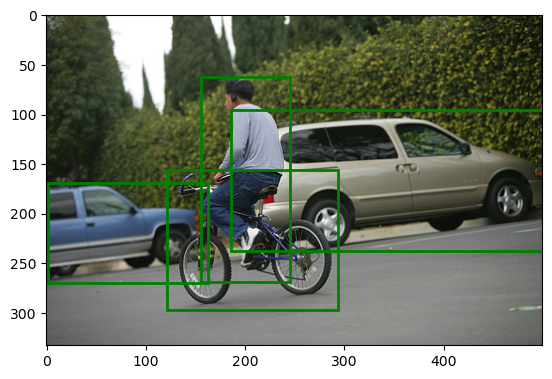

In [13]:
idx = torch.randint(low=0, high=len(val_data), size=(1,))

print(f"IDX: {idx.item()}\n")
image, gt_bbox, gt_class, gt_attributes, pred_attr, pred_score_attr = inference_attr(
    idx=idx
)
plot_inference_attr(image, gt_bbox, gt_class, gt_attributes, pred_attr, pred_score_attr)

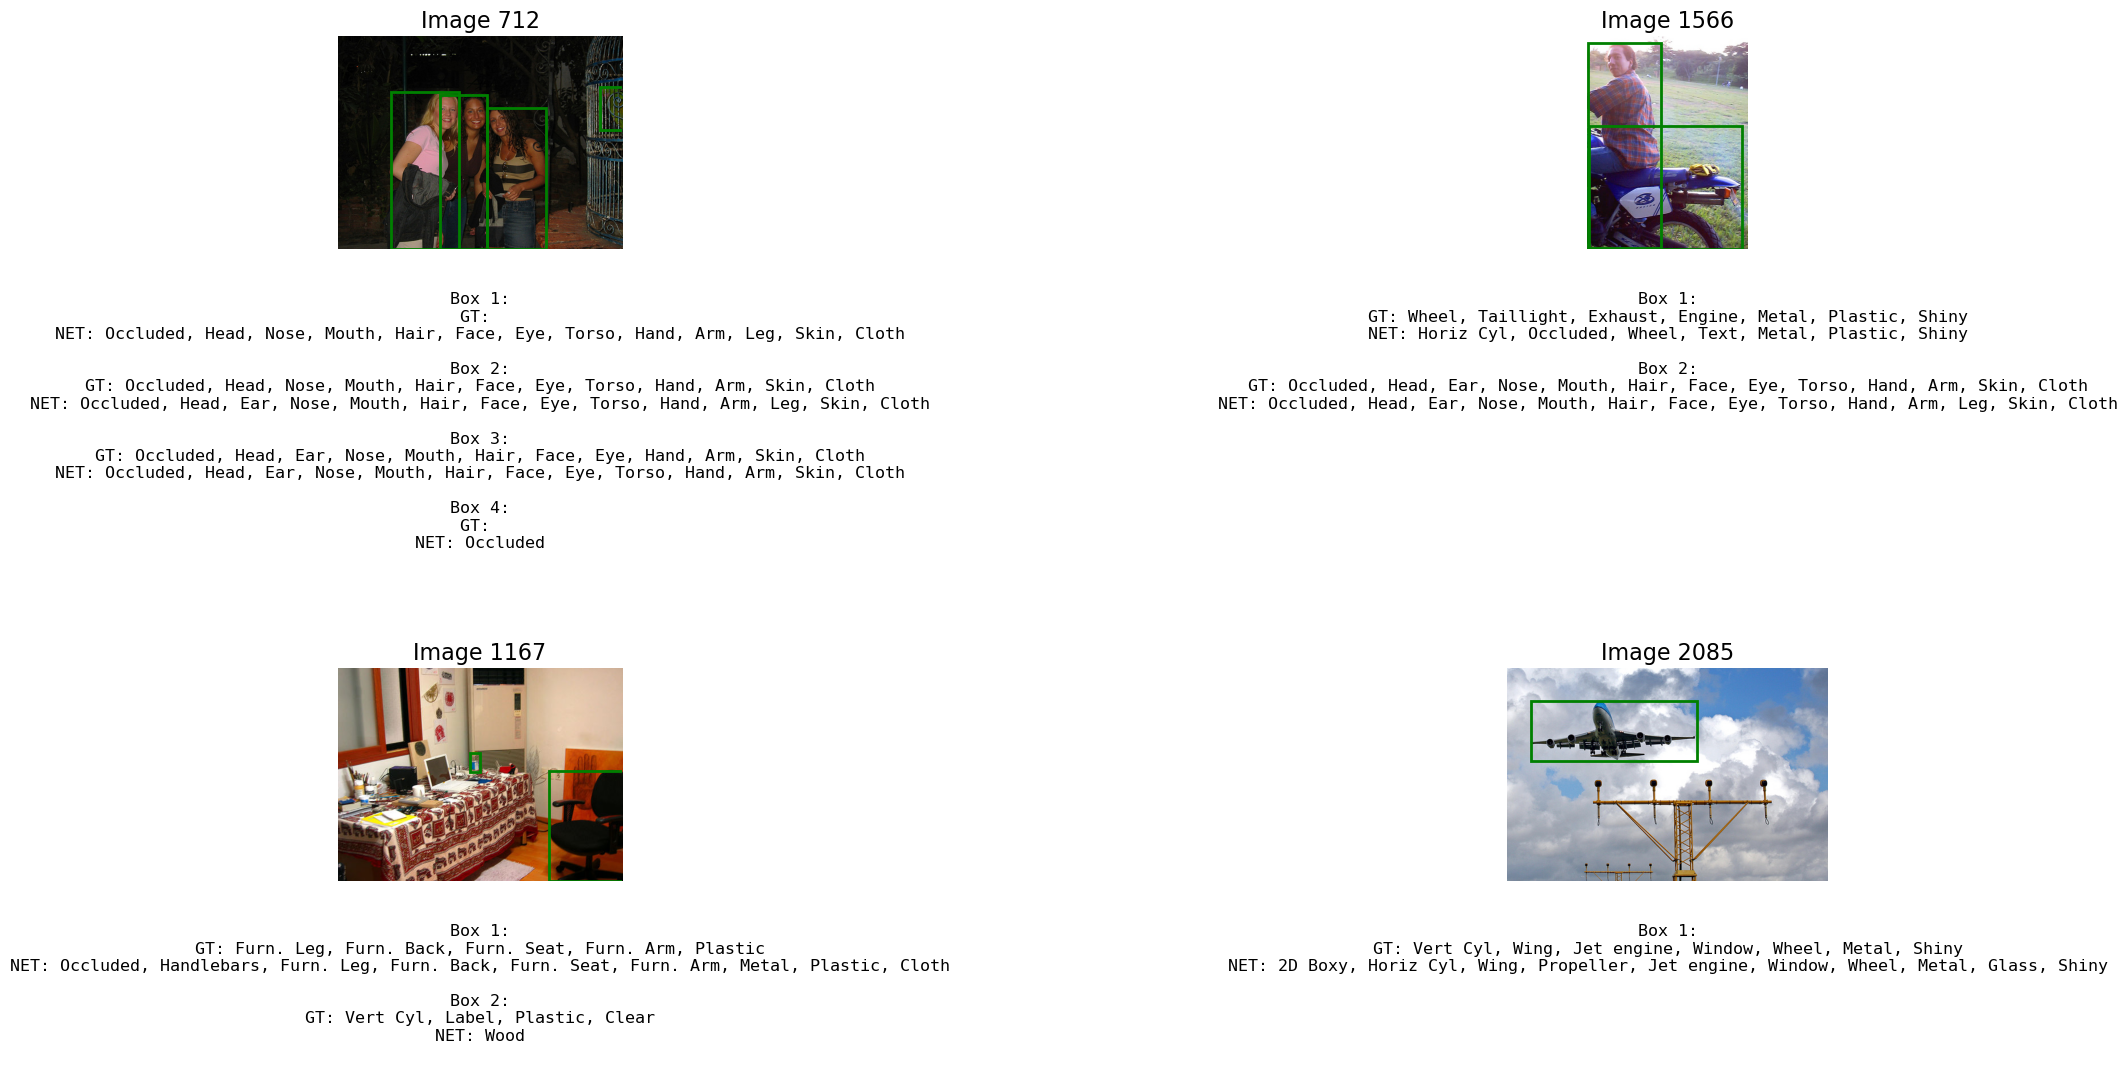

In [15]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def inference_attr(idx):
    img_transform, _, _, gt_bbox_transform, _, _ = val_data_for_model[idx]
    img_transform = img_transform.unsqueeze(0).to(device)
    gt_bbox_transform = gt_bbox_transform.to(device)

    image, _, gt_class, gt_bbox, gt_attributes, _ = val_data[idx]

    indices_batch = torch.zeros(gt_bbox_transform.shape[0], device=device).unsqueeze(-1)
    pred_attr, pred_score_attr = model.prediction_rois(
        img_transform, gt_bbox_transform, indices_batch
    )
    return (
        image,
        gt_bbox,
        gt_class,
        gt_attributes,
        pred_attr.cpu(),
        pred_score_attr.cpu(),
    )


def get_names_attributes(attributes):
    indices = torch.nonzero(attributes == 1.0, as_tuple=True)[0] + 1
    return [val_data.id2attribute[(idx)] for idx in indices.tolist()]


def plot_multiple_inference_attr(num_images=8):
    rows = 2
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
    axes = axes.flatten()

    for i in range(num_images):
        idx = torch.randint(low=0, high=len(val_data), size=(1,)).item()
        image, gt_bbox, _, gt_attributes, pred_attr, _ = inference_attr(idx=idx)

        ax = axes[i]
        ax.imshow(image)

        # Plot GT bounding boxes
        for gt_el in gt_bbox:
            x_min, y_min, x_max, y_max = gt_el
            rect = patches.Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=2,
                edgecolor="g",
                facecolor="none",
            )
            ax.add_patch(rect)

        # Prepare the attribute group for each bounding box
        table_info = ""
        for j, (gt_attr, net_attr) in enumerate(zip(gt_attributes, pred_attr)):
            gt_attr_names = ", ".join(get_names_attributes(gt_attr))
            net_attr_names = ", ".join(get_names_attributes(net_attr))
            table_info += f"Box {j+1}:\nGT: {gt_attr_names}\nNET: {net_attr_names}\n\n"

        # Handling cases where there are more GT attributes than predicted
        for j in range(len(gt_attributes) - len(pred_attr)):
            gt_attr_names = ", ".join(
                get_names_attributes(gt_attributes[len(pred_attr) + j])
            )
            table_info += (
                f"Box {len(pred_attr) + j + 1}:\nGT: {gt_attr_names}\nNET: N/A\n\n"
            )

        ax.axis("off")
        ax.set_title(f"Image {idx}", fontsize=16)

        # Add text below the image using ax.text
        ax.text(
            0.5,
            -0.2,
            table_info,
            fontsize=12,
            ha="center",
            va="top",
            transform=ax.transAxes,
            family="monospace",
        )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# Display 4 images in a 2x2 grid
plot_multiple_inference_attr(num_images=4)